在这里，损失函数尝试使用AM-Softmax，直接在github扒下来的代码
在四分类上用AM-Softmax损失函数进行训练

In [1]:
import tensorflow as tf


In [2]:
def am_softmax_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35

    label = tf.reshape(tf.argmax(y_true, axis=-1), shape=(-1, 1))
    label = tf.cast(label, dtype=tf.int32)  # y
    batch_range = tf.reshape(tf.range(tf.shape(y_pred)[0]), shape=(-1, 1))  # 0~batchsize-1
    indices_of_groundtruth = tf.concat([batch_range, tf.reshape(label, shape=(-1, 1))],
                                       axis=1)  # 2columns vector, 0~batchsize-1 and label
    groundtruth_score = tf.gather_nd(y_pred, indices_of_groundtruth)  # score of groundtruth

    m = tf.constant(margin, name='m')
    s = tf.constant(scale, name='s')

    added_margin = tf.cast(tf.greater(groundtruth_score, m),
                           dtype=tf.float32) * m  # if groundtruth_score>m, groundtruth_score-m
    added_margin = tf.reshape(added_margin, shape=(-1, 1))
    added_embeddingFeature = tf.subtract(y_pred, y_true * added_margin) * s  # s(cos_theta_yi-m), s(cos_theta_j)

    cross_ent = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=added_embeddingFeature)
    loss = tf.reduce_mean(cross_ent)
    return loss


In [3]:

from keras import models
from keras import layers


Using TensorFlow backend.


In [4]:
model  = models.Sequential()
#卷积层，参数意义分别为：
#经过这一层之后，特征图的个数，一个卷积核，产生一个特征图，第一层：32，说明有32个卷积核；第二层64，说明在第一层的特征图基础上，每张特征图有两个卷积核进行特征采集
#卷积核大小
#激活函数
#输入大小（只在开始的第一层有，后面不需要）
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(400,100,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))


In [5]:
#配置模型的损失函数、优化器、指标名称
from keras import optimizers

model.compile(loss=am_softmax_loss,          #损失函数
optimizer=optimizers.RMSprop(lr=1e-4),             #优化器
metrics=['acc'])                                   #指标名称


In [6]:
#图片的训练路径和验证路径
train_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\train'
validation_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\val'


In [7]:
#生成训练需要的图片和标签
from keras.preprocessing.image import ImageDataGenerator
#将图片大小调整到1以内，原先图片每个像素的格式为uint8，所以要除以255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

#根据目录的名称，生成对应的标签
#train_dir有Ⅱ型和Ⅲ型的图片
#每次生成batch_size数量的图片，图片大小为target_size
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(400, 100),              #生成图片的大小
batch_size=26,                       #一次生成图片的数量
class_mode='categorical')                 #图片标签的类型

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(400, 100),              #生成图片的大小
batch_size=10,                       #一次生成图片的数量
class_mode='categorical')                 #图片标签的类型


Found 2600 images belonging to 4 classes.
Found 790 images belonging to 4 classes.


In [8]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='实验1.2_best.h5',monitor='val_acc',mode='auto' ,save_best_only='True')

history = model.fit_generator(
train_generator,                           #通过生成器传入图片和标签
steps_per_epoch=100,                       #分100次传入，每次26张
epochs=50,                                 #总共训练40轮
validation_data=validation_generator,      #通过生成器传入图片和标签进行验证
validation_steps=79,                       #分60次传入，每次10张
callbacks = [checkpoint]
)

Epoch 1/50
100/100 [==============================] - 17s 170ms/step - loss: 2.7271 - acc: 0.7292 - val_loss: 0.8716 - val_acc: 0.8190

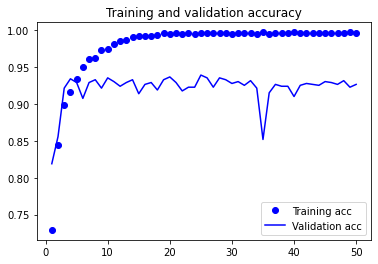

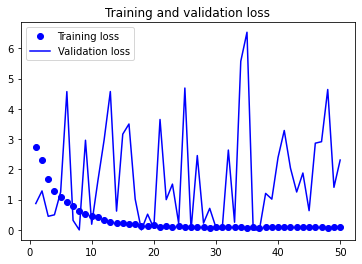

In [9]:
#绘制训练精度、验证精度
#绘制训练损失、验证损失
#python画图库，类似matlab的plot
import matplotlib.pyplot as plt
acc = history.history['acc']             #得到训练的指标数据
val_acc = history.history['val_acc']     #得到验证的指标数据
loss = history.history['loss']           #得到训练损失
val_loss = history.history['val_loss']   #得到验证损失
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('多分类1.2_accuracy_50.png')
plt.legend()                              #画图例
plt.figure()                              #另一张图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('多分类1.2_loss_50.png')
plt.legend()
plt.show()                                #画图，最后加上

In [10]:
# 保存每轮的精度和损失

file = open('多分类1.2_acc_loss_50.txt','a')
file.write('训练精度：')
for i in acc :
    file.write(str(i))
    file.write(" ")
file.write("\n")
file.write('验证精度：')
for i in val_acc :
    file.write(str(i))
    file.write(" ")


file.write("\n")
file.write('训练损失：')
for i in loss :
    file.write(str(i))
    file.write(" ")

file.write("\n")
file.write('验证损失：')
for i in val_loss :
    file.write(str(i))
    file.write(" ")

file.close()

In [11]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
best_model = load_model('实验1.2_best.h5', custom_objects={'am_softmax_loss':am_softmax_loss})


import os
import numpy as np

II_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\val\II'
III_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\val\III'
O_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\val\O'
n_dir = r'G:\useful_L\Normal2\NEW_NET_4.0\val\N'

def my_image(path):
    out = []
    filenames = os.listdir(path)
    for filename in filenames:
        image = load_img(os.path.join(path, filename), target_size= (400,100))
        image = img_to_array(image)
        image = image/255.0
        out.append(image)
    return np.array(out)

imgs_II = my_image(II_dir)
imgs_III = my_image(III_dir)
imgs_O = my_image(O_dir)
imgs_n = my_image(n_dir)

ret_II = best_model.predict_classes(imgs_II)
ret_III = best_model.predict_classes(imgs_III)
ret_O = best_model.predict_classes(imgs_O)
ret_n = best_model.predict_classes(imgs_n)

ret_II = ret_II.tolist()
ret_III = ret_III.tolist()
ret_O = ret_O.tolist()
ret_N = ret_n.tolist()


II_II = ret_II.count(0)
II_III = ret_II.count(1)
II_N = ret_II.count(2)
II_O = ret_II.count(3)


III_II = ret_III.count(0)
III_III = ret_III.count(1)
III_N = ret_III.count(2)
III_O = ret_III.count(3)

N_II = ret_N.count(0)
N_III = ret_N.count(1)
N_N = ret_N.count(2)
N_O = ret_N.count(3)


O_II = ret_O.count(0)
O_III = ret_O.count(1)
O_N = ret_O.count(2)
O_O = ret_O.count(3)

print("len ret_II is {:d} ".format(len(ret_II)))
print("len ret_III is {:d} ".format(len(ret_III)))
print("len ret_n is {:d} ".format(len(ret_N)))
print("len ret_O is {:d} ".format(len(ret_O)))
print("________________________________")
print("II_II is {:d}".format(II_II))
print("II_III is {:d}".format(II_III))
print("II_N is {:d}".format(II_N))
print("II_O is {:d}".format(II_O))
print("________________________________")
print("III_II is {:d}".format(III_II))
print("III_III is {:d}".format(III_III))
print("III_N is {:d}".format(III_N))
print("III_O is {:d}".format(III_O))
print("________________________________")
print("N_II is {:d}".format(N_II))
print("N_III is {:d}".format(N_III))
print("N_N is {:d}".format(N_N))
print("N_O is {:d}".format(N_O))
print("________________________________")
print("O_II is {:d}".format(O_II))
print("O_III is {:d}".format(O_III))
print("O_N is {:d}".format(O_N))
print("O_O is {:d}".format(O_O))

len ret_II is 70 
len ret_III is 120 
len ret_n is 300 
len ret_O is 300 
________________________________
II_II is 54
II_III is 2
II_N is 1
II_O is 13
________________________________
III_II is 7
III_III is 103
III_N is 1
III_O is 9
________________________________
N_II is 0
N_III is 1
N_N is 298
N_O is 1
________________________________
O_II is 6
O_III is 4
O_N is 3
O_O is 287


In [12]:
from keras.models import load_model

def am_softmax_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35

    label = tf.reshape(tf.argmax(y_true, axis=-1), shape=(-1, 1))
    label = tf.cast(label, dtype=tf.int32)  # y
    batch_range = tf.reshape(tf.range(tf.shape(y_pred)[0]), shape=(-1, 1))  # 0~batchsize-1
    indices_of_groundtruth = tf.concat([batch_range, tf.reshape(label, shape=(-1, 1))],
                                       axis=1)  # 2columns vector, 0~batchsize-1 and label
    groundtruth_score = tf.gather_nd(y_pred, indices_of_groundtruth)  # score of groundtruth

    m = tf.constant(margin, name='m')
    s = tf.constant(scale, name='s')

    added_margin = tf.cast(tf.greater(groundtruth_score, m),
                           dtype=tf.float32) * m  # if groundtruth_score>m, groundtruth_score-m
    added_margin = tf.reshape(added_margin, shape=(-1, 1))
    added_embeddingFeature = tf.subtract(y_pred, y_true * added_margin) * s  # s(cos_theta_yi-m), s(cos_theta_j)

    cross_ent = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=added_embeddingFeature)
    loss = tf.reduce_mean(cross_ent)
    return loss


best_model = load_model('实验1.2_best.h5', custom_objects={'am_softmax_loss':am_softmax_loss})

loss,acc = best_model.evaluate(validation_generator)

print(loss, acc)

79/79 [==============================] - 2s 29ms/step